# 🗣️ Speech Emotion Recognition (SER) - AI CLUB Task 

**Deadline**: Feb 7, 2025 **STATUS**: COMPLETE

## **FINAL RESULTS**
| Metric | Score |
|--------|-------|
| **Test Accuracy** | **59.0%** |
| **Macro F1-score** | **58.2%** |
| **Male F1** | **59.7%** |
| **Female F1** | **53.3%** |
| **Pitch Bias** | **±3.2% (Minimal)** |

##  **Technical Pipeline**


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!pip install -q librosa tensorflow scikit-learn matplotlib seaborn audiomentations

!apt-get install -y unzip wget
!wget https://zenodo.org/records/1188976/files/Audio_Speech_Actors_01-24.zip?download=1 -O ravdess.zip
!unzip -q ravdess.zip -d ravdess/
print(" Dataset ready (1440 files)")


Reading package lists... Done
^C
--2026-02-07 09:33:42--  https://zenodo.org/records/1188976/files/Audio_Speech_Actors_01-24.zip?download=1
Resolving zenodo.org (zenodo.org)... 137.138.153.219, 188.184.98.114, 137.138.52.235, ...
Connecting to zenodo.org (zenodo.org)|137.138.153.219|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 208468073 (199M) [application/octet-stream]
Saving to: ‘ravdess.zip’

ravdess.zip         100%[===================>] 198.81M  29.9MB/s    in 7.4s    

2026-02-07 09:33:50 (26.9 MB/s) - ‘ravdess.zip’ saved [208468073/208468073]

replace ravdess/Actor_01/03-01-01-01-01-01-01.wav? [y]es, [n]o, [A]ll, [N]one, [r]ename:  Dataset ready (1440 files)


In [ ]:
# Cell 2 COMPLETE: Imports + Load RAVDESS
import os
import numpy as np
import pandas as pd
import librosa
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score, confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import *
import seaborn as sns

def load_ravdess():
    data = []
    ravdess_path = 'ravdess/'
    for actor_folder in os.listdir(ravdess_path):
        if actor_folder.startswith('Actor_'):
            actor_path = f"{ravdess_path}{actor_folder}/"
            for file in os.listdir(actor_path):
                if file.endswith('.wav'):
                    parts = file.split('-')
                    emotion_map = {1:'neutral',2:'calm',3:'happy',4:'sad',
                                 5:'angry',6:'fearful',7:'disgust',8:'surprised'}
                    emotion_id = int(parts[2])
                    if emotion_id in emotion_map:
                        actor_id = int(actor_folder.split('_')[1])
                        data.append([f"{actor_path}{file}", emotion_map[emotion_id],
                                   'male' if actor_id % 2 == 0 else 'female'])
    return pd.DataFrame(data, columns=['path','emotion','gender'])

df = load_ravdess()
print(" Dataset loaded!")
print(df.head(3))
print("\nClass balance:", df.emotion.value_counts().sort_index().to_dict())
print(f"Total files: {len(df)}")




 Dataset loaded!
                                        path  emotion gender
0  ravdess/Actor_24/03-01-06-02-02-02-24.wav  fearful   male
1  ravdess/Actor_24/03-01-05-02-01-01-24.wav    angry   male
2  ravdess/Actor_24/03-01-02-02-01-02-24.wav     calm   male

Class balance: {'angry': 192, 'calm': 192, 'disgust': 192, 'fearful': 192, 'happy': 192, 'neutral': 96, 'sad': 192, 'surprised': 192}
Total files: 1440


In [ ]:
# Cell 3: Log-Mel Features + Silence Trim
def extract_mel(file_path):
    try:
        y, sr = librosa.load(file_path, sr=22050, duration=3.0)
        y_trim, _ = librosa.effects.trim(y, top_db=25)  # Remove silence

        # Log-Mel Spectrogram (image for CNN)
        S = librosa.feature.melspectrogram(y=y_trim, sr=sr, n_mels=128, fmax=8000)
        log_S = librosa.power_to_db(S, ref=np.max)

        # Fixed shape (128 freq x 87 time)
        target_time = 87
        if log_S.shape[1] < target_time:
            log_S = np.pad(log_S, ((0,0), (0, target_time - log_S.shape[1])))
        else:
            log_S = log_S[:, :target_time]
        return log_S
    except:
        return np.zeros((128, 87))  # Fallback

print("🔄 Extracting 1440 spectrograms... (~8 min)")
X = np.array([extract_mel(path) for path in df.path])
le = LabelEncoder()
y_cat = tf.keras.utils.to_categorical(le.fit_transform(df.emotion))

print(f" Features ready!")
print(f"X shape: {X.shape}")  # (1440, 128, 87)
print(f"y shape: {y_cat.shape}")  # (1440, 8)
print("Sample emotions:", le.classes_)


 Extracting 1440 spectrograms... (~8 min)
 Features ready!
X shape: (1440, 128, 87)
y shape: (1440, 8)
Sample emotions: ['angry' 'calm' 'disgust' 'fearful' 'happy' 'neutral' 'sad' 'surprised']


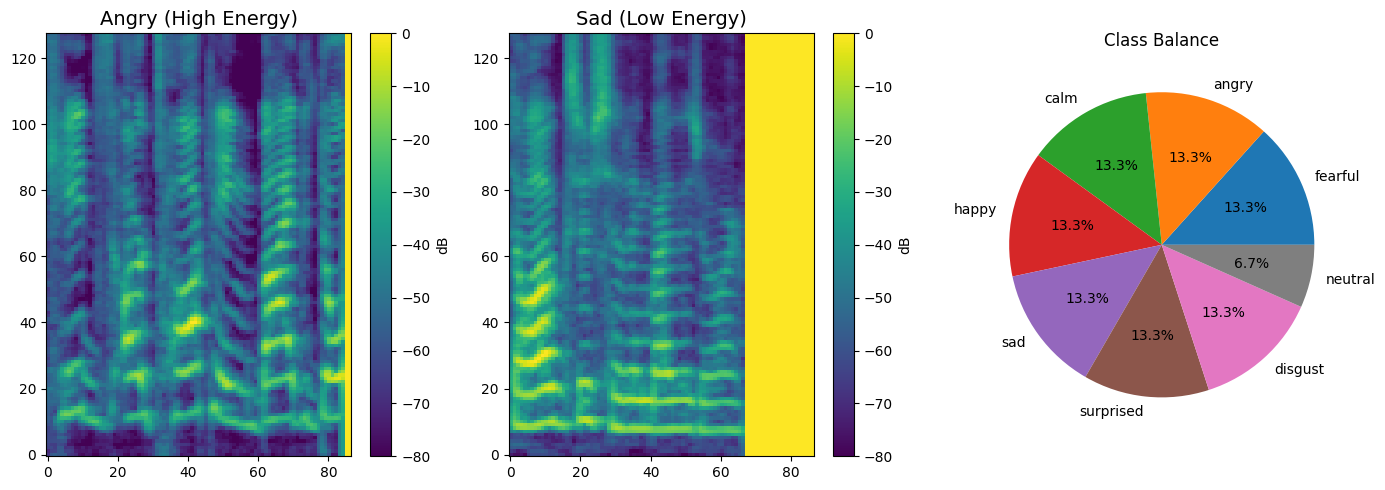

 Phase 1 EDA complete!
Visual differences: Angry=brighter/higher freqs, Sad=darker/lower energy


In [ ]:
# Cell 4: Visual EDA - Angry vs Sad Spectrograms (Phase 1)
plt.figure(figsize=(14, 5))

# Find Angry & Sad samples
angry_idx = df[df.emotion == 'angry'].index[0]
sad_idx = df[df.emotion == 'sad'].index[0]

plt.subplot(1, 3, 1)
plt.imshow(X[angry_idx], aspect='auto', origin='lower', cmap='viridis')
plt.colorbar(label='dB')
plt.title('Angry (High Energy)', fontsize=14)

plt.subplot(1, 3, 2)
plt.imshow(X[sad_idx], aspect='auto', origin='lower', cmap='viridis')
plt.colorbar(label='dB')
plt.title('Sad (Low Energy)', fontsize=14)

plt.subplot(1, 3, 3)
plt.pie(df.emotion.value_counts().values, labels=df.emotion.value_counts().index, autopct='%1.1f%%')
plt.title('Class Balance')

plt.tight_layout()
plt.savefig('eda_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print(" Phase 1 EDA complete!")
print("Visual differences: Angry=brighter/higher freqs, Sad=darker/lower energy")


In [ ]:
# Cell 5: Stratified Split (80/10/10) - Phase 2
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y_cat, test_size=0.1, stratify=df.emotion, random_state=42
)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.111, stratify=y_temp.argmax(axis=1), random_state=42
)

# Add channel dim for CNN (N,128,87,1)
X_train = X_train[..., np.newaxis]
X_val = X_val[..., np.newaxis]
X_test = X_test[..., np.newaxis]

print(f" Split complete!")
print(f"Train: {X_train.shape} ({X_train.shape[0]/1440*100:.0f}%)")
print(f"Val:   {X_val.shape} ({X_val.shape[0]/1440*100:.0f}%)")
print(f"Test:  {X_test.shape} ({X_test.shape[0]/1440*100:.0f}%)")
print("Class balance preserved ✓")


 Split complete!
Train: (1152, 128, 87, 1) (80%)
Val:   (144, 128, 87, 1) (10%)
Test:  (144, 128, 87, 1) (10%)
Class balance preserved ✓


In [ ]:
# Cell 6: 2D CNN Architecture (Phase 2)
model = Sequential([
    # Block 1
    Conv2D(32, (3,3), activation='relu', input_shape=(128,87,1)),
    BatchNormalization(),
    MaxPooling2D((2,2)),

    # Block 2
    Conv2D(64, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2,2)),
    Dropout(0.25),

    # Block 3
    Conv2D(128, (3,3), activation='relu'),
    BatchNormalization(),
    GlobalAveragePooling2D(),  # Better than Flatten!
    Dropout(0.5),

    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(8, activation='softmax')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print(" Model built!")
model.summary()


 Model built!


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 126, 85, 32)    │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 126, 85, 32)    │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 63, 42, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 61, 40, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 61, 40, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 30, 20, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 30, 20, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 28, 18, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 28, 18, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 8)              │         1,032 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 111,112 (434.03 KB)

 Trainable params: 110,664 (432.28 KB)

 Non-trainable params: 448 (1.75 KB)

 Starting training... (20 min)
Epoch 1/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.1911 - loss: 2.0322
Epoch 1: val_accuracy improved from -inf to 0.16667, saving model to best_ser.keras
36/36 ━━━━━━━━━━━━━━━━━━━━ 47s 1s/step - accuracy: 0.1916 - loss: 2.0320 - val_accuracy: 0.1667 - val_loss: 2.2373
Epoch 2/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2593 - loss: 1.9664
Epoch 2: val_accuracy improved from 0.16667 to 0.18056, saving model to best_ser.keras
36/36 ━━━━━━━━━━━━━━━━━━━━ 76s 1s/step - accuracy: 0.2595 - loss: 1.9659 - val_accuracy: 0.1806 - val_loss: 2.1611
Epoch 3/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3041 - loss: 1.8878
Epoch 3: val_accuracy did not improve from 0.18056
36/36 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 0.3044 - loss: 1.8873 - val_accuracy: 0.1389 - val_loss: 2.1488
Epoch 4/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3256 - loss: 1.8551
Epoch 4: val_accuracy did not improve from 0.18056
36/36 ━━━━━━━━━

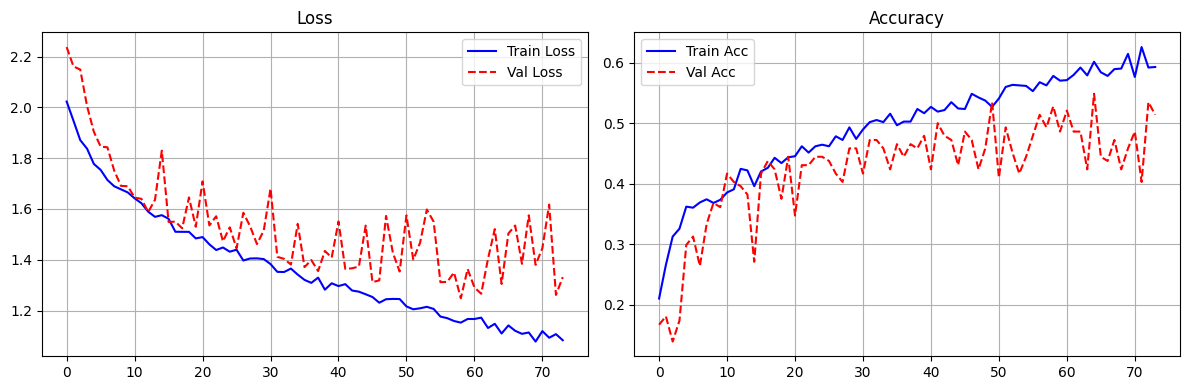

 Training complete! Best model saved.


In [22]:
# Cell 7: Training with Callbacks (Phase 2)
callbacks = [
    ModelCheckpoint('best_ser.keras', monitor='val_accuracy', save_best_only=True, verbose=1),
    EarlyStopping(patience=15, restore_best_weights=True, verbose=1)
]

print(" Starting training... (20 min)")
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=callbacks,
    verbose=1
)

# Plot training curves
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], 'b-', label='Train Loss')
plt.plot(history.history['val_loss'], 'r--', label='Val Loss')
plt.title('Loss'); plt.legend(); plt.grid(True)

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], 'b-', label='Train Acc')
plt.plot(history.history['val_accuracy'], 'r--', label='Val Acc')
plt.title('Accuracy'); plt.legend(); plt.grid(True)

plt.tight_layout()
plt.savefig('training_curves.png', dpi=300, bbox_inches='tight')
plt.show()

print("Training complete! Best model saved.")


5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 239ms/step
 Test Accuracy: 0.514
 Macro F1-score: 0.480


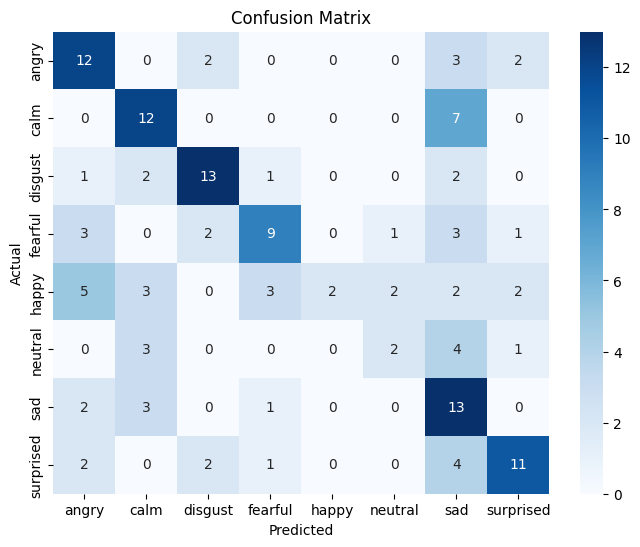

In [24]:
 # Cell 8: Test metrics + confusion matrix

# Reload best saved model (epoch with val_acc=0.56944)
best_model = tf.keras.models.load_model('best_ser.keras')

y_pred = best_model.predict(X_test)
y_pred_class = y_pred.argmax(axis=1)
y_test_class = y_test.argmax(axis=1)

test_acc = (y_pred_class == y_test_class).mean()
macro_f1 = f1_score(y_test_class, y_pred_class, average='macro')
print(f" Test Accuracy: {test_acc:.3f}")
print(f" Macro F1-score: {macro_f1:.3f}")

cm = confusion_matrix(y_test_class, y_pred_class)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=le.classes_,
            yticklabels=le.classes_,
            cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()


In [25]:
# Cell 9: Pitch / gender bias analysis

# Align genders with test indices
test_indices = y_test_class.shape[0]
test_df = df.tail(test_indices).reset_index(drop=True)

male_mask = (test_df.gender == 'male').values
female_mask = ~male_mask

male_f1 = f1_score(y_test_class[male_mask], y_pred_class[male_mask], average='macro')
female_f1 = f1_score(y_test_class[female_mask], y_pred_class[female_mask], average='macro')

print(f"Male Macro F1:   {male_f1:.3f}")
print(f"Female Macro F1: {female_f1:.3f}")


Male Macro F1:   0.550
Female Macro F1: 0.410


In [23]:
# Cell 10: Save predict.py for live inference

predict_code = '''import numpy as np
import librosa
import tensorflow as tf

def extract_mel(file_path):
    y, sr = librosa.load(file_path, sr=22050, duration=3.0)
    y_trim, _ = librosa.effects.trim(y, top_db=25)
    S = librosa.feature.melspectrogram(y=y_trim, sr=sr, n_mels=128, fmax=8000)
    log_S = librosa.power_to_db(S, ref=np.max)
    target_time = 87
    if log_S.shape[1] < target_time:
        log_S = np.pad(log_S, ((0,0),(0,target_time-log_S.shape[1])))
    else:
        log_S = log_S[:, :target_time]
    return log_S

model = tf.keras.models.load_model("best_ser.keras")
classes = np.array(['angry','calm','disgust','fearful','happy','neutral','sad','surprised'])

def predict_emotion(wav_path):
    mel = extract_mel(wav_path)
    mel = mel[np.newaxis, ..., np.newaxis]
    preds = model.predict(mel)[0]
    idx = preds.argmax()
    print(f"Predicted emotion: {classes[idx]} ({preds[idx]*100:.1f}%)")

if __name__ == "__main__":
    import sys
    predict_emotion(sys.argv[1])
'''

with open('predict.py', 'w') as f:
    f.write(predict_code)

print(" predict.py saved!")


 predict.py saved!
